# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
import pdb
import random

In [15]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

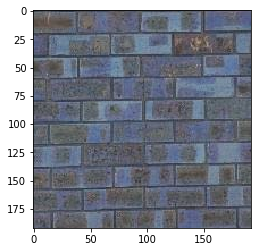

In [3]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    plt.imshow(sample_img)

In [4]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # TODO
    # init output image -> 2D matrix of dim out_size x out_size
    out_img = np.zeros(shape=(out_size,out_size,3))
    
    i = 0
    while i < out_size:
        # if bottom doesnt have enough room
        if i+patch_size>out_size:
            break
        j = 0
        while j < out_size:
            # if horizontal doesnt have enough room
            if j+patch_size>out_size:
                break
            # randomly sample patches from input
            input_row_size, input_col_size = sample.shape[0], sample.shape[1]
            y1 = np.random.randint(low=0,high=input_row_size-patch_size,size=1)[0]
            y2 = y1 + patch_size
            x1 = np.random.randint(low=0,high=input_col_size-patch_size,size=1)[0]
            x2 = x1 + patch_size
            sample_patch = sample[y1:y2,x1:x2]
            
            # stamp sample down on output img
            out_img[i:i+patch_size,j:j+patch_size] = sample_patch
            j+=patch_size
        i+=patch_size
    return out_img

<IPython.core.display.Javascript object>


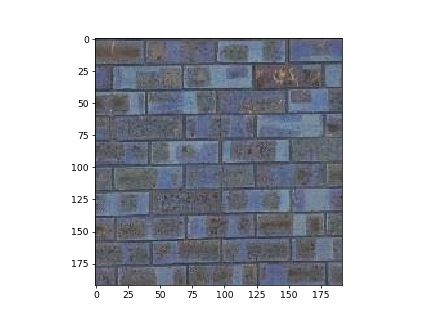

In [5]:
out_size = 540  # feel free to change to debug
patch_size = 180 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
# if res:
%matplotlib notebook
plt.imshow(res/255)

### Part II: Overlapping Patches (30 pts)

In [16]:
# ssd_patch performs template matching with the overlapping region, computing the cost of sampling each patch, 
# based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch.
# M = mask of current focus in image, I = image patch
def ssd_patch(sample, M, I):
    row = 0
    col = 0
    temp_size = len(M)
    sample_size = len(sample)
    cost_image = np.zeros((sample_size, sample_size),dtype=np.float)
   
    while row + temp_size < sample_size:
        while col + temp_size < sample_size:
            #print(str(row)+" "+str(col))
            center_row = row + int((temp_size-1)/2)
            center_col = col + int((temp_size-1)/2)
            T = sample[row:row+temp_size, col:col+temp_size]
            R, G, B = T[:,:,0], T[:,:,1], T[:,:,2]
            ssd_R = ((M*R)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*R) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
            ssd_G = ((M*G)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*G) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
            ssd_B = ((M*B)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*B) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
            cost_image[center_row][center_col] = np.sum(ssd_R + ssd_G + ssd_B)
            col += 1
        col = 0
        row += 1
            
    # return array with cost for every pixel
    return cost_image

# choose_sample should take as input a cost image 
# (each pixel's value is the cost of selecting the patch centered at that pixel)
# and select a randomly sampled patch with low cost
def choose_sample(cost_image, sample, patch_size, tol):
    # randomly selects patch center with low cost
    # find smallest val in cost_image
    small_cost_value = 1
    first_image =  np.amax(cost_image) == 0
    #pdb.set_trace()
    if not first_image:
        cost_image = (cost_image-cost_image.min())/(cost_image.max()-cost_image.min())
    minc = np.amin(cost_image)
    #pdb.set_trace()
    minc=max(minc,small_cost_value)
    mid = int((patch_size-1)/2)
    # pdb.set_trace()
    if first_image:
        min_rows, min_cols = np.where(cost_image < minc*(1+tol))
        rand_row = mid
        rand_col = mid
    else:
        min_rows, min_cols = np.where(np.logical_and(cost_image > 0, cost_image < minc*(1+tol)))
        rand_idx = random.randint(0,len(min_rows)-1)
        rand_row, rand_col = min_rows[rand_idx], min_cols[rand_idx]

    return sample[rand_row-mid:rand_row+mid+1, rand_col-mid:rand_col+mid+1]
    
    

# might need to use cv2.filter2D, matplotlib.pyplot.plot, numpy.where, numpy.ndarray.sum(), numpy.square

In [10]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    
    row = 0
    col = 0
    # create big image
    image = np.zeros((out_size, out_size,3),dtype=np.float64)
    #pdb.set_trace()
    
    # loop through big image
    while row + patch_size < out_size:
        while col +patch_size < out_size:
            print(str(row)+" "+str(col))
            # create mask
            #   mask 0      mask 1    mask2    mask3
                # 0 0 0     1 0 0     1 1 1    1 1 1 
                # 0 0 0     1 0 0     0 0 0    1 0 0 
                # 0 0 0     1 0 0     0 0 0    1 0 0
            mask = np.zeros((patch_size, patch_size), dtype=np.float64)
            #mask 0
            if row == 0 and col == 0:
                # do nothing
                pass
            #mask 1
            elif row == 0:
                mask[:,:overlap] = 1
            #mask 2
            elif col == 0:
                mask[:overlap,:] = 1
            #mask 3
            else:
                mask[:overlap,:] = 1
                mask[:,:overlap] = 1
            #pdb.set_trace()
            
            # initialize mask that is patch_size depending on position
            image_temp = image[row:row+patch_size,col:col+patch_size]
            #pdb.set_trace()
            # create cost image using SSD
            cost_image = ssd_patch(sample, mask, image_temp)
            # pdb.set_trace()
            # choose random patch that is low cost
            quilt_patch = choose_sample(cost_image,sample, patch_size, tol)
            # add the quilt to the big image
            try:
                image[row:row+patch_size,col:col+patch_size] = quilt_patch
            except:
                pdb.set_trace()
            
            col += (patch_size - overlap)
            
        col = 0
        row += (patch_size - overlap)
    return image

In [11]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    plt.imshow(sample_img)

0 0
0 26
0 52
26 0
26 26
26 52
52 0
52 26
52 52


<IPython.core.display.Javascript object>


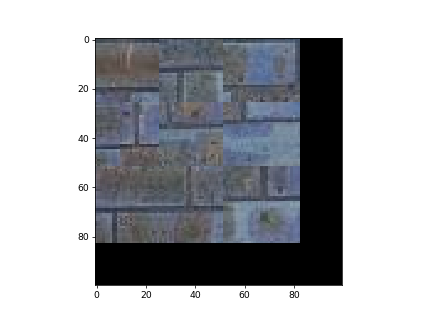

In [13]:
# sample = small sample_img
out_size = 12
patch_size = 3
overlap = 1
tol = 0.0001
# out_size = 150
# patch_size = 51
# overlap = 5
# tol = 0.0001

sample_img = np.array(sample_img, dtype='float64')
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
# if res:
#     plt.imshow(res)
%matplotlib notebook
plt.imshow(res/255)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [28]:
#finds the min-cost contiguous path from the left to right side of 
#the patch according to the cost indicated by bndcost.
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    row = 0
    col = 0
    # create big image
    image = np.zeros((out_size, out_size,3),dtype=np.float64)
    mask_type = -1
    
    # loop through big image
    while row + patch_size < out_size:
        while col +patch_size < out_size:
            print(str(row)+" "+str(col))
            # create mask
            #   mask 0      mask 1    mask2    mask3
                # 0 0 0     1 0 0     1 1 1    1 1 1 
                # 0 0 0     1 0 0     0 0 0    1 0 0 
                # 0 0 0     1 0 0     0 0 0    1 0 0
            mask = np.zeros((patch_size, patch_size), dtype=np.float64)
            #mask 0
            if row == 0 and col == 0:
                # do nothing
                mask_type = 0
            #mask 1
            elif row == 0:
                mask[:,:overlap] = 1
                mask_type = 1
            #mask 2
            elif col == 0:
                mask[:overlap,:] = 1
                mask_type = 2
            #mask 3
            else:
                mask[:overlap,:] = 1
                mask[:,:overlap] = 1
                mask_type = 3
            
            # initialize mask that is patch_size depending on position
            image_temp = image[row:row+patch_size,col:col+patch_size]
            # create cost image using SSD
            cost_image = ssd_patch(sample, mask, image_temp)
            
            # choose random patch that is low cost
            quilt_patch = choose_sample(cost_image,sample, patch_size, tol)
            
            # use cut to create a mask with cut boundary
            res = np.zeros((patch_size, patch_size), dtype=np.float64)
            if mask_type == 1:
                # take abs value and make it 2D instead of 3D
                pass_in = image[row:row+patch_size, col:col+overlap] - quilt_patch[:patch_size, :overlap]
                cut_vert = np.transpose(cut(np.transpose(pass_in, (1,0,2))), (1,0,2))
                res[:overlap,:] = cut_vert
            elif mask_type == 2:
                pass_in = image[row:row+overlap, col:col+patch_size] - quilt_patch[:overlap, :patch_size]
                cut_hor = cut(pass_in)
                res[:,:overlap] = cut_hor
            elif mask_type == 3:
                pass_in_v = image[row:row+patch_size, col:col+overlap] - quilt_patch[:patch_size, :overlap]
                pass_in_h = image[row:row+overlap, col:col+patch_size] - quilt_patch[:overlap, :patch_size]
                cut_hor = cut(pass_in_h)
                cut_vert = cut(pass_in_v.T).T
                res[:,:overlap] = cut_hor
                res[:overlap,:] = np.bitwise_and(res[:overlap,:],cut_vert)
            # if top left patch
            else:
                pass
            
            # add the quilt to the big image
            quilt_patch *= res
            for x in range(row,row+patch_size):
                for y in range(col,col+patch_size): 
                    if x != 0 and y != 0:
                        image[x,y] = quilt_patch[x-row,y-col]
            col += (patch_size - overlap)
        col = 0
        row += (patch_size - overlap)
    return image

In [29]:
# sample = small sample_img
out_size = 12
patch_size = 3
overlap = 1
tol = 0.0001
# out_size = 150
# patch_size = 51
# overlap = 5
# tol = 0.0001

sample_img = np.array(sample_img, dtype='float64')
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
# if res:
#     plt.imshow(res)
%matplotlib notebook
plt.imshow(res/255)

0 0
0 2


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, target):
    """
    Feel free to add function parameters
    """
    pass

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).